# Lendable Senior Data Analyst — Take Home Test

**Author:** Yogi Cahyono  \
**E-Mail:** yogitricahyono@gmail.com  \
**Date:** _2025-12-15_

## Table of Contents
1. [Methodology & Plan](#methodology)
2. [Recommendations & Next Steps](#recommendations)
3. [Data Loading & Preparation](#data-prep)
4. [Exploratory Data Analysis and Key Findings](#eda) 
5. [Personal Traits vs Success - Logistic Regression](#traits)

<a id="methodology"></a>
## 1. Methodology & Plan

### 1.1 Objectives & Deliverables
| # | Task | How this notebook addresses it |
|---|------|------------------------------|
| **A** | Perform data analysis and highlight 5 interesting findings | Section 4 & 5 summarises EDA and model insights with evidence |
| **B** | Identify personal traits linked to successful outcomes | Section 5 analyses `credit_features.csv` + merges with applications. Build Logistic Regression model and analyse the results.|
| **C** | Present the solution | Entire narrative: methodology → recommendations → findings |

### 1.2 Assessment Criteria Checklist
- [v] Explain analysis methodology ([Section 1](#methodology) & throughout)
- [v] Provide actionable recommendations ([Section 2](#methodology))
- [v] Call out anomalous findings ([Section 4.3.1 onwards](#anomalies))
- [v] Highlight key indicators of loan success ([Sections 4](#model_insights_1))

### 1.3 Analytical Approach
1. **Understand the data**: schema review and data dictionary understanding.
2. **EDA & segmentation**: temporal trends, loan characteristics, feature engineering.
3. **Quantify drivers**: logistic regression and statistical tests.
4. **Synthesize insights**: connect findings to business recommendations.
5. **Document decisions**: emphasise reasoning over pure code.

<a id="recommendations"></a>
## 2. Recommendations & Next Steps (Deliverable C)

| # | Recommendation | Rationale | Expected Impact |
|---|----------------|-----------|-----------------|
| 1 | **Standardise loan purpose inputs at source** | Loan purpose is captured as free text, creating 2,444 spelling/phrase variations that scatter risk insight across near-duplicate entries. With the current fragmentation, the true asset allocation is unclear, making it hard to tie purpose directly to risk. | Understand applicant intent, track capital exposure by purpose, and calculate purpose-specific risk profiles |
| 2 | **Eliminate unpopular half-year term options** | 18, 30, 42, 54-month terms have <20 applications—statistically unreliable | Simplify product portfolio and focus analytics on significant segments |
| 3 | **Route "No Credit History" applicants to alternative review** | 100% auto-rejection (ALL_Count=0) excludes potentially good customers and violates linear models assumption | Capture new revenue from thin-file customers; improve model stability |
| 4 | **Promote 36 & 48 month loan terms** | 36- and 48-month terms have significantly higher odds of success than 12-month terms (~2.9× and 3.5× respectively). | Increase portfolio success rate by guiding applicants toward optimal terms |
| 5 | **Reassess conservative 10% approval rate** | Current strategy sacrifices 90% of volume—marginally riskier customers may still be profitable | Unlock growth while maintaining acceptable risk thresholds |

### Next Analytical Steps
- Train a sentence-embedding model (e.g., sentence-transformers/all-MiniLM or spaCy vectors) on the cleaned LoanPurpose text to group loan purpose into bigger group before running Logistic Regression model.
- Build a secondary scorecard for "thin-file" applicants using 'additional' alternative data (cash-flow, employment verification)

<a id="data-prep"></a>
## 3. Data Loading & Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

In [2]:
APPLICATION_PATH = 'data/application_samples.csv'
CREDIT_PATH = 'data/credit_features.csv'
SCHEMA_PATH = 'data/data_dictionary.csv'

application_df = pd.read_csv(APPLICATION_PATH)
credit_df = pd.read_csv(CREDIT_PATH)
schema_df = pd.read_csv(SCHEMA_PATH)

print(application_df.shape)
print(credit_df.shape)
display(schema_df)

(8847, 7)
(8847, 14)


,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


In [3]:
schema_df

,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


In [4]:
def preprocess_applications(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and engineer base application fields."""
    df = df.copy()
    df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], dayfirst=True)
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df['Term'] = pd.to_numeric(df['Term'], errors='coerce')
    df['Month'] = df['ApplicationDate'].dt.to_period('M').dt.to_timestamp()
    df['Quarter'] = df['ApplicationDate'].dt.to_period('Q').astype(str)
    df['SuccessLabel'] = df['Success'].map({1: 'Success', 0: 'Fail'})
    return df

application_df = preprocess_applications(application_df)

<a id="eda"></a>
## 4. Exploratory Data Analysis and Key Findings (Deliverable A)

### 4.1 Data Quality & Overview

In [5]:
application_df.info()
display(application_df['Success'].value_counts(normalize=True).mul(100).round(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   UID              8847 non-null   int64         
 1   ApplicationDate  8847 non-null   datetime64[ns]
 2   Amount           8847 non-null   int64         
 3   Term             8847 non-null   int64         
 4   EmploymentType   8847 non-null   object        
 5   LoanPurpose      8847 non-null   object        
 6   Success          8847 non-null   int64         
 7   Month            8847 non-null   datetime64[ns]
 8   Quarter          8847 non-null   object        
 9   SuccessLabel     8847 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 691.3+ KB


Success
0    89.6
1    10.4
Name: proportion, dtype: float64

**`📊 Key Finding #1:`**   
A 10% acceptance rate reflects a conservative, low-risk strategy, strictly filtering for the most secure borrowers. While this minimizes default risk, the business sacrifices 90% of potential volume, missing opportunities among marginally riskier, but possibly profitable, customers.

---

In [6]:
print('First Application Date', application_df.ApplicationDate.min(), '| Last Application Date', application_df.ApplicationDate.max())

First Application Date 2020-01-01 00:00:00 | Last Application Date 2020-12-31 00:00:00


The dataset covers all loan applications submitted over a full one-year period, specifically from the start of January 1, 2020, through the end of December 31, 2020.

---

### 4.2 Temporal Trends & Key Findings

#### 4.2.1 Number of Monthly & Quarterly Application

**`📊 Key Finding #2:`**   
- **Stable approval volume**: Monthly trends show no significant divergence between successful and failed applications throughout 2020. While rejections remain consistently high, the number of successful applications stays relatively stable from January to December.
- **Inverse relationship in quarterly data**: Total applications decline from Q1 to Q4, yet success rate improves — suggesting either stricter pre-screening or improved applicant quality over time.
- **No COVID-19 disruption visible** in application volumes (2020 was pandemic year but 
patterns appear normal)


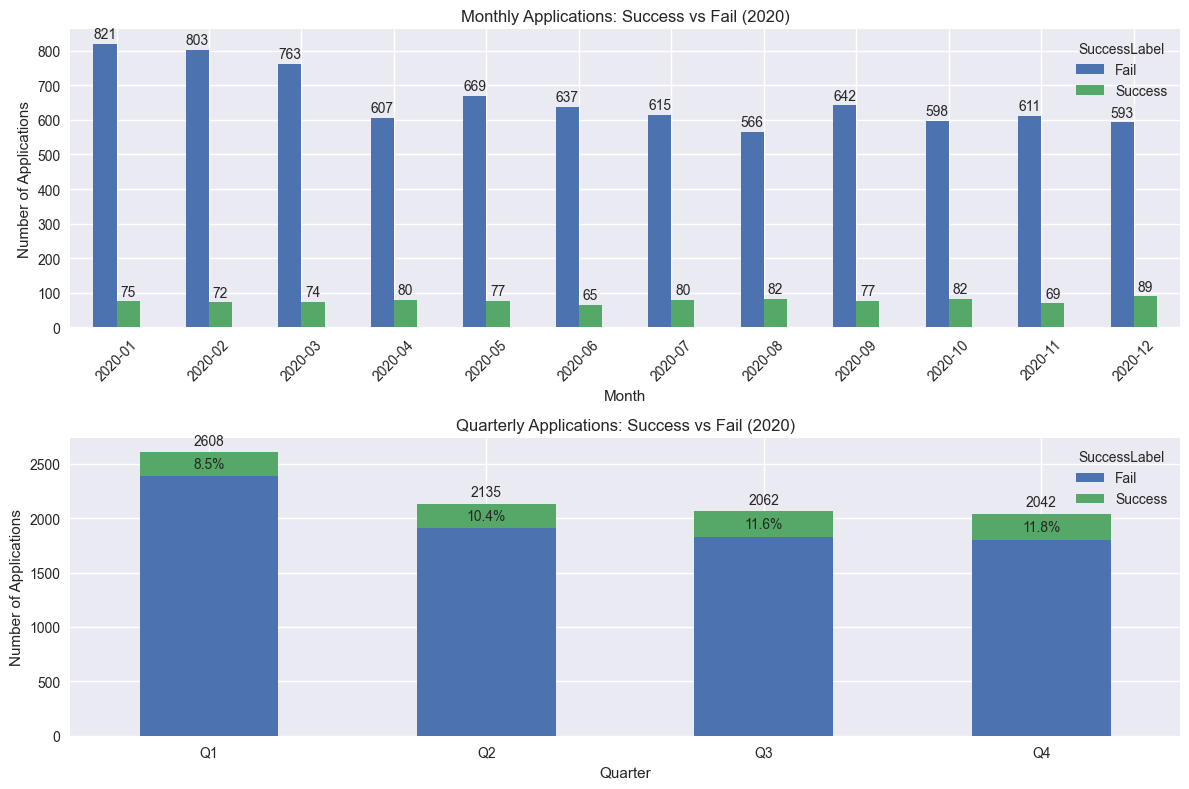

In [7]:
# Helper for bar labels
def add_bar_labels(ax):
    for container in ax.containers:
        ax.bar_label(container, padding=2, fmt="%.0f")

# Monthly data
monthly_count = (
    application_df.groupby(["Month", "SuccessLabel"])["UID"]
           .count()
           .unstack(fill_value=0)
)

# Quarterly data
application_df["Quarter"] = application_df["Month"].dt.quarter
quarterly_count = (
    application_df.groupby(["Quarter", "SuccessLabel"])["UID"]
           .count()
           .unstack(fill_value=0)
)

# Calculate quarterly success percentage
quarterly_count["Total"] = quarterly_count["Fail"] + quarterly_count["Success"]
quarterly_count["Success_Pct"] = (quarterly_count["Success"] / quarterly_count["Total"] * 100).round(1)

# Create figure with 2 rows
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ===== Row 1: Monthly Applications =====
ax1 = axes[0]
monthly_count.index = monthly_count.index.strftime("%Y-%m")
monthly_count.plot(kind="bar", ax=ax1)
ax1.set_title("Monthly Applications: Success vs Fail (2020)")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Applications")
ax1.tick_params(axis='x', rotation=45)
add_bar_labels(ax1)

# ===== Row 2: Quarterly Applications with Success % =====
ax2 = axes[1]
quarterly_count.index = ["Q1", "Q2", "Q3", "Q4"]
quarterly_count[["Fail", "Success"]].plot(kind="bar", stacked=True, ax=ax2)
ax2.set_title("Quarterly Applications: Success vs Fail (2020)")
ax2.set_xlabel("Quarter")
ax2.set_ylabel("Number of Applications")
ax2.tick_params(axis='x', rotation=0)

# Labels: Total on top, Success percentage inside orange bar
bars_fail, bars_success = ax2.containers

# Total applications on top of each stacked bar
ax2.bar_label(bars_success, labels=quarterly_count["Total"].astype(int), label_type="edge", padding=3)

# Success percentage inside the orange (Success) bar
ax2.bar_label(bars_success, labels=[f"{p}%" for p in quarterly_count["Success_Pct"]], label_type="center")

plt.tight_layout()
plt.show()

---

#### 4.2.2 Loan Amount Trends by Month & Quarter

**`📊 Key Finding #3:`**   

- Stable disbursement amount: Similar to the volume trend, the total monetary value of successful loans remained consistent from January to December. The business maintained stable capital deployment throughout the year, with no significant volatility in the total amount lent per month.

- Inverse relationship in capital efficiency: The total dollar amount requested declined from Q1 to Q4, yet the "success" value held steady or improved. This indicates higher capital efficiency in the latter half of the year—the business approved a larger portion of the requested funds despite a drop in total demand.

- Resilient purchasing power: There is no COVID-19 disruption visible in the requested loan sizes. Borrowers did not scale back their financial needs, as the average ticket size and total requested amounts followed normal seasonal patterns rather than showing signs of economic contraction.

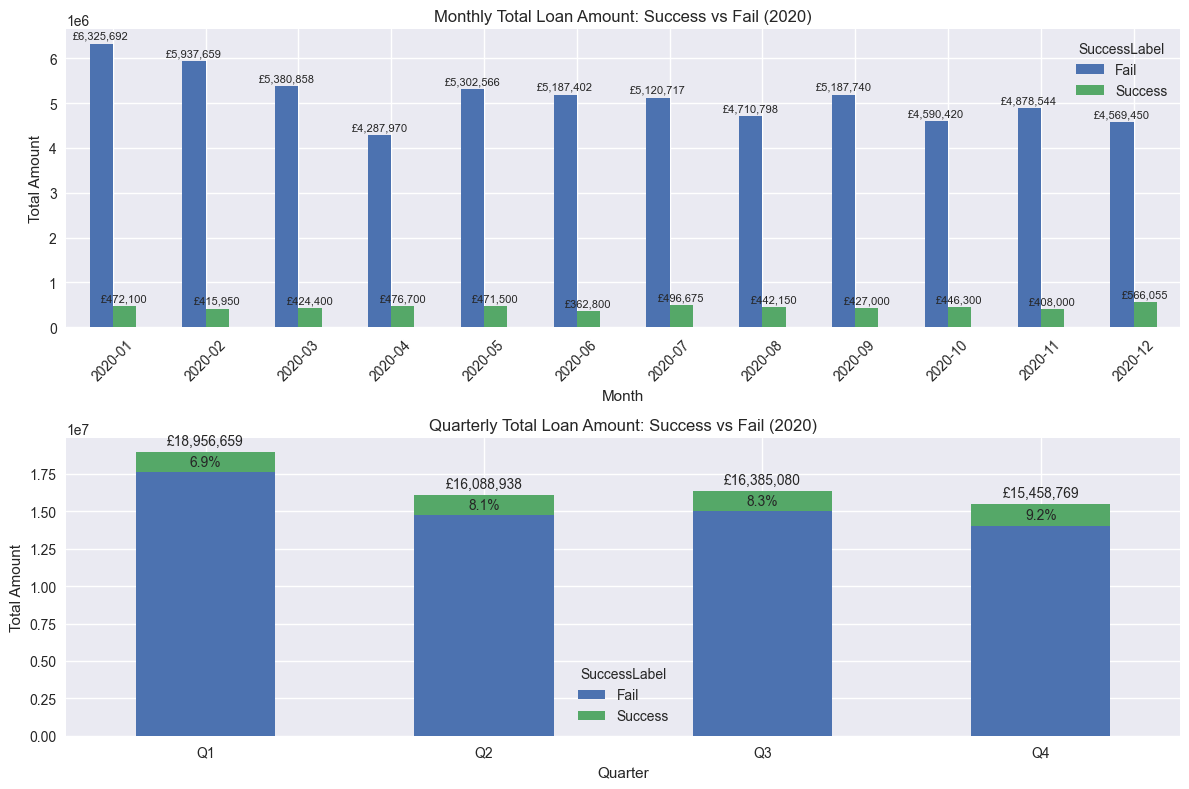

In [8]:
# Monthly amount data
monthly_amount = (
    application_df.groupby(["Month", "SuccessLabel"])["Amount"]
           .sum()
           .unstack(fill_value=0)
)

# Quarterly amount data
application_df["Quarter"] = application_df["Month"].dt.quarter
quarterly_amount = (
    application_df.groupby(["Quarter", "SuccessLabel"])["Amount"]
           .sum()
           .unstack(fill_value=0)
)

# Calculate quarterly totals and success percentage
quarterly_amount["Total"] = quarterly_amount["Fail"] + quarterly_amount["Success"]
quarterly_amount["Success_Pct"] = (quarterly_amount["Success"] / quarterly_amount["Total"] * 100).round(1)

# Create figure with 2 rows
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ===== Row 1: Monthly Loan Amount =====
ax1 = axes[0]
monthly_amount.index = monthly_amount.index.strftime("%Y-%m")
monthly_amount.plot(kind="bar", ax=ax1)
ax1.set_title("Monthly Total Loan Amount: Success vs Fail (2020)")
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Amount")
ax1.tick_params(axis='x', rotation=45)

# Custom formatted labels for monthly chart (£ and thousands separator)
for container in ax1.containers:
    ax1.bar_label(container, labels=[f"£{v:,.0f}" for v in container.datavalues], padding=2, fontsize=8)

# ===== Row 2: Quarterly Loan Amount with Success % =====
ax2 = axes[1]
quarterly_amount.index = ["Q1", "Q2", "Q3", "Q4"]
quarterly_amount[["Fail", "Success"]].plot(kind="bar", stacked=True, ax=ax2)
ax2.set_title("Quarterly Total Loan Amount: Success vs Fail (2020)")
ax2.set_xlabel("Quarter")
ax2.set_ylabel("Total Amount")
ax2.tick_params(axis='x', rotation=0)

# Labels: Total on top, Success percentage inside success bar
bars_fail, bars_success = ax2.containers

# Total amount on top of each stacked bar
ax2.bar_label(bars_success, labels=[f"£{t:,.0f}" for t in quarterly_amount["Total"]], label_type="edge", padding=3)

# Success percentage inside success bar
ax2.bar_label(bars_success, labels=[f"{p}%" for p in quarterly_amount["Success_Pct"]], label_type="center")

plt.tight_layout()
plt.show()

---

<a id="anomalies"></a>

### 4.3 Loan Characteristics
#### 4.3.1 Loan Term Distribution & Success Patterns

**`📊 Key Finding #4:`**   

- Before pre-processing we can see loan terms non yearly multiplication (18, 30, 42, 54) has significantly low number of application. Because of that reason we group them to get better insight and visualisation.

- **30-36 and 42-48 month terms have highest success rates** while **12 and 54-60 month terms has lowest success rates** (important predictor in modelling).

- **Grouping reveals clear patterns**: Mid-term loans (30-48 months) perform better than short or long terms

**`❗Anomalies Observed:`**

- Evidence: The left chart displays a pattern where terms that are multiples of 12 (12, 24, 36, 48, 60) have massive application volumes (ranging from ~900 to over 2,600). In contrast, the intermediate 6-month intervals (18, 30, 42, 54) have drastically lower volumes, with the 42-month term being almost invisible (approx. 10-20 total applications).

- Interpretation: This indicates a significant behavioural anomaly where borrowers almost exclusively favour annualized milestones. Consequently, the "Success" and "Fail" rates for the half-year terms are based on such small sample sizes that they are statistically unreliable and "noisy" compared to the full-year terms.

- Action/Question: The business should consider eliminating these unpopular half-year term options to simplify the product portfolio, or strictly analyse them in grouped brackets (as shown in the right graph) to avoid making decisions based on insignificant data.

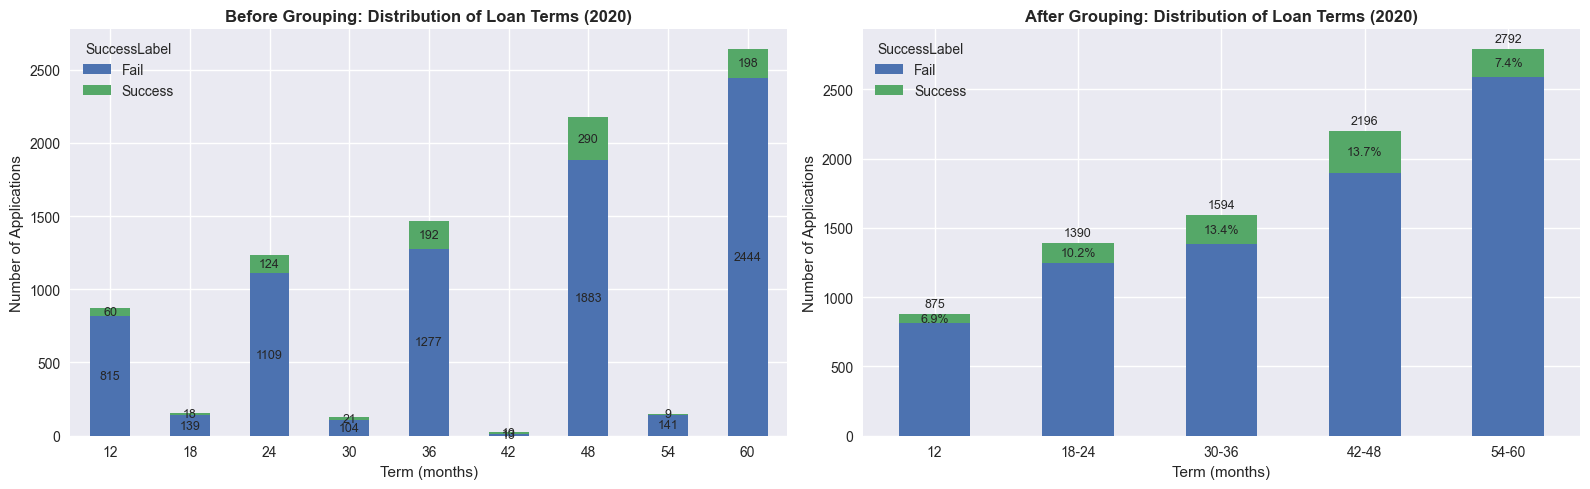

In [9]:
# Create grouped term column
def group_terms(term):
    if term == 12:
        return '12'
    elif term in [18, 24]:
        return '18-24'
    elif term in [30, 36]:
        return '30-36'
    elif term in [42, 48]:
        return '42-48'
    elif term in [54, 60]:
        return '54-60'
    else:
        return str(term)

application_df['Term_grouped'] = application_df['Term'].apply(group_terms)

# ===== BEFORE: Original Terms =====
term_split = (
    application_df.groupby(["Term", "SuccessLabel"])["UID"]
           .count()
           .unstack(fill_value=0)
           .sort_index()
)

# ===== AFTER: Grouped Terms =====
term_grouped_split = (
    application_df.groupby(["Term_grouped", "SuccessLabel"])["UID"]
           .count()
           .unstack(fill_value=0)
)
# Reorder for logical display
order = ['12', '18-24', '30-36', '42-48', '54-60']
term_grouped_split = term_grouped_split.loc[order]

# ===== Create side-by-side comparison =====
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Before grouping
ax1 = axes[0]
term_split.plot(kind="bar", stacked=True, ax=ax1)
ax1.set_title("Before Grouping: Distribution of Loan Terms (2020)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Term (months)")
ax1.set_ylabel("Number of Applications")
ax1.tick_params(axis='x', rotation=0)

bars_fail, bars_success = ax1.containers
ax1.bar_label(bars_fail, labels=term_split["Fail"].astype(int), label_type="center", fontsize=9)
ax1.bar_label(bars_success, labels=term_split["Success"].astype(int), label_type="center", fontsize=9)

# Right: After grouping
ax2 = axes[1]
term_grouped_split.plot(kind="bar", stacked=True, ax=ax2)
ax2.set_title("After Grouping: Distribution of Loan Terms (2020)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Term (months)")
ax2.set_ylabel("Number of Applications")
ax2.tick_params(axis='x', rotation=0)

# Totals and success percentages for grouped terms
totals_grouped = term_grouped_split["Fail"] + term_grouped_split["Success"]
success_pct_grouped = (term_grouped_split["Success"] / totals_grouped * 100).round(1)

bars_fail2, bars_success2 = ax2.containers

# Total applications on top of each stacked bar
ax2.bar_label(
    bars_success2,
    labels=totals_grouped.astype(int),
    label_type="edge",
    padding=3,
    fontsize=9,
)

# Success percentage inside the orange (Success) bar
ax2.bar_label(
    bars_success2,
    labels=[f"{p}%" for p in success_pct_grouped],
    label_type="center",
    fontsize=9,
)

plt.tight_layout()
plt.show()


#### 4.3.2 Top Loan Purpose Distribution & Success Rate

**1. Introduction**  
* This analysis examines the variability in loan application reasons to identify true portfolio drivers. The raw dataset contained **2,444 unique entries** for loan purposes throughout 2020, heavily fragmented by typos and synonyms. By applying basic standardization (e.g., lowercasing strings and grouping semantic synonyms like "Consolidation" and "Debt Consolidation"), we reduced this to **1,674 unique categories**. 
* While this improved clarity, the process highlights a need for more robust pre-processing, as synonymous categories like "Car" and "New Car" remain distinct, diluting the signal for vehicle-related loans.

**2.`📊 Key Finding #5:`**   
Unmasking the True Portfolio Driver
* **Observation:** In the raw data, "Car" appeared to be the dominant category with **1,372 applications**. However, after standardizing and merging synonyms, **"Debt Consolidation"** surged to the top spot with **2,072 applications**.
* **Implication:** Poor data hygiene previously masked the portfolio's primary exposure. The business is predominantly funding **debt relief**, not **asset purchases**. This is a critical distinction, as debt consolidators typically carry a higher risk profile (often due to existing credit utilization) compared to borrowers purchasing tangible assets.

**3. Further Development Required**
To permanently resolve data fragmentation, the solution must move upstream to the product interface:
* **Restrict Input Variance:** Replace open text fields with a standardised, multi-level dropdown menu (e.g., *Category: Vehicle* $\rightarrow$ *Sub-Category: New Car*). This eliminates typo-induced fragmentation at the source, ensuring data enters the pipeline in a clean, structured format.

**4. Benefits of Implementation**
Standardizing inputs yields three critical business advantages:
* **Immediate Data Hygiene:** Eliminates the "clean-up tax" of fixing typos and case sensitivity, saving analysts hours of manual reconciliation every month.
* **Maximized Statistical Power:** Forces low-volume variations (e.g., "New Car") into correct high-volume parent groups ("Vehicle"), ensuring the model has sufficient data to make statistically valid risk predictions for every segment.
* **Real-Time Automation:** Structured data enables instant auto-decisioning. The system can immediately flag high-risk categories like "Debt Consolidation" for specific logic, whereas free text requires complex parsing before a decision can be made.

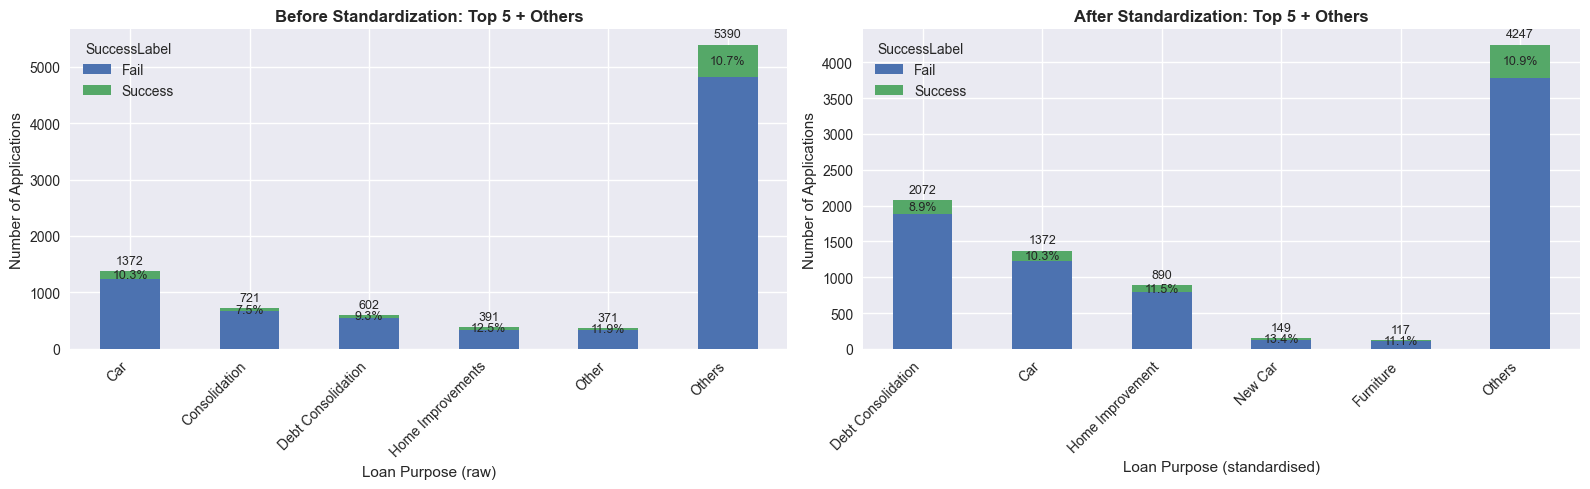

In [10]:
# ===== BEFORE: Raw loan purposes (pre-standardization) — Top 5 + Others =====

# Step 1: Lowercase and strip whitespace
application_df["LoanPurpose_clean"] = (
    application_df["LoanPurpose"]
    .astype(str)
    .str.strip()
    .str.lower()
)

raw_top5_names = (
    application_df["LoanPurpose_clean"]
        .value_counts()
        .head(5)
        .index
        .tolist()
)

# Step 2: Map to standardised categories using keyword matching
def standardize_loan_purpose(purpose):
    purpose = purpose.lower()
    
    # Debt consolidation variants
    if any(word in purpose for word in ['consolidat', 'debt']):
        return 'debt consolidation'
    
    # Home improvement variants
    if 'home' in purpose and 'improv' in purpose:
        return 'home improvement'
    
    # Add more mappings as needed:
    # if 'car' in purpose or 'vehicle' in purpose:
    #     return 'vehicle'
    # if 'wedding' in purpose:
    #     return 'wedding'
    
    # Keep as-is for unmatched
    return purpose

application_df["LoanPurpose_standardized"] = (
    application_df["LoanPurpose_clean"]
    .apply(standardize_loan_purpose)
)

# Create grouped column: keep top 5, rename rest to "others"
application_df["LoanPurpose_raw_grouped"] = application_df["LoanPurpose_clean"].apply(
    lambda x: x if x in raw_top5_names else "others"
)

raw_split = (
    application_df.groupby(["LoanPurpose_raw_grouped", "SuccessLabel"])["UID"]
        .count()
        .unstack(fill_value=0)
)

# Reorder: top 5 in descending order, then "others" at the end
raw_order = raw_top5_names + ["others"]
raw_split = raw_split.loc[raw_order]
raw_split["Total"] = raw_split["Fail"] + raw_split["Success"]
raw_split["Success_Pct"] = (raw_split["Success"] / raw_split["Total"] * 100).round(1)
raw_split.index = raw_split.index.str.replace('_', ' ').str.title()

# ===== AFTER: Standardised loan purposes — Top 5 + Others =====
std_top5 = (
    application_df[application_df["LoanPurpose_standardized"] != "other"]["LoanPurpose_standardized"]
        .value_counts()
        .head(5)
)
std_top5_names = std_top5.index.tolist()

application_df["LoanPurpose_grouped"] = application_df["LoanPurpose_standardized"].apply(
    lambda x: x if x in std_top5_names else "others"
)

std_split = (
    application_df.groupby(["LoanPurpose_grouped", "SuccessLabel"])["UID"]
          .count()
          .unstack(fill_value=0)
)
std_order = std_top5_names + ["others"]
std_split = std_split.loc[std_order]
std_split["Total"] = std_split["Fail"] + std_split["Success"]
std_split["Success_Pct"] = (std_split["Success"] / std_split["Total"] * 100).round(1)
std_split.index = std_split.index.str.replace('_', ' ').str.title()

# ===== Visualise side-by-side =====
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left axis: BEFORE standardization (Top 5 + Others)
raw_split[["Fail", "Success"]].plot(kind="bar", stacked=True, ax=axes[0])
axes[0].set_title("Before Standardization: Top 5 + Others", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Loan Purpose (raw)")
axes[0].set_ylabel("Number of Applications")
axes[0].tick_params(axis='x', rotation=45)
for label in axes[0].get_xticklabels():
    label.set_ha('right')

bars_fail_raw, bars_success_raw = axes[0].containers
axes[0].bar_label(bars_success_raw, labels=raw_split["Total"].astype(int), label_type="edge", padding=3, fontsize=9)
axes[0].bar_label(bars_success_raw, labels=[f"{p}%" for p in raw_split["Success_Pct"]], label_type="center", fontsize=9)

# Right axis: AFTER standardization (Top 5 + Others)
std_split[["Fail", "Success"]].plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("After Standardization: Top 5 + Others", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Loan Purpose (standardised)")
axes[1].set_ylabel("Number of Applications")
axes[1].tick_params(axis='x', rotation=45)
for label in axes[1].get_xticklabels():
    label.set_ha('right')

bars_fail_std, bars_success_std = axes[1].containers
axes[1].bar_label(bars_success_std, labels=std_split["Total"].astype(int), label_type="edge", padding=3, fontsize=9)
axes[1].bar_label(bars_success_std, labels=[f"{p}%" for p in std_split["Success_Pct"]], label_type="center", fontsize=9)

plt.tight_layout()
plt.show()

#### 4.3.3 Employment Type Distribution & Success Rate

**`📊 Key Finding #6:`**   
- **Volume Disparity:** There is a massive difference in volume between full-time employees and all other categories. Full-time applications (7,714) account for the vast majority of the data shown, dwarfing the next largest category (Part Time at 570).
- **Success Rates vs. Volume:** While Part Time employees represent a much smaller pool of applicants, they have the highest likelihood of "Success" at 13.7%.
- **Riskier Category:** Self Employed applicants appear to have the lowest success rate at only 6.7%, suggesting this category might be viewed as higher risk or harder to approve in this specific context (likely loan or credit applications).

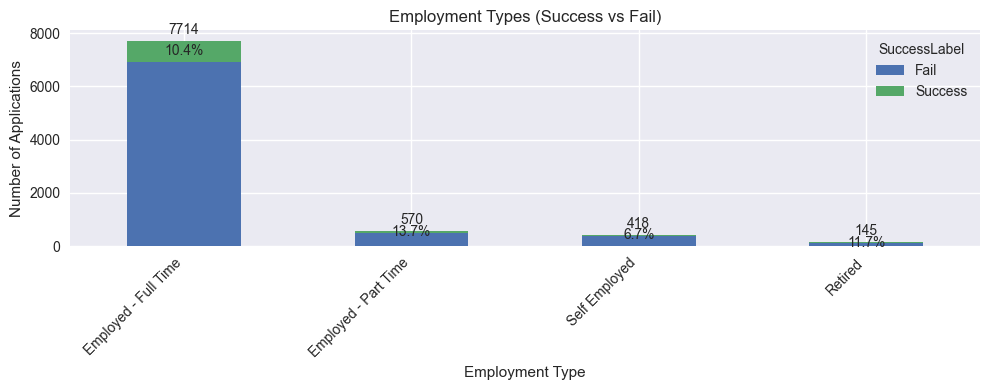

In [11]:
# Normalise EmploymentType text
application_df["EmploymentType_clean"] = (
    application_df["EmploymentType"]
        .astype(str)
        .str.strip()
        .str.lower()
)

# Get top 10 employment types by count
top10_emp = (
    application_df["EmploymentType_clean"]
        .value_counts()
        .head(10)
)

top10_emp_names = top10_emp.index

# Filter data to only top 10
df_emp = application_df[application_df["EmploymentType_clean"].isin(top10_emp_names)]

# Compute success/fail count per employment type
emp_split = (
    df_emp.groupby(["EmploymentType_clean", "SuccessLabel"])["UID"]
          .count()
          .unstack(fill_value=0)
)

# Reorder rows to match top 10 order (descending)
emp_split = emp_split.loc[top10_emp_names]

# Beautify labels
emp_split.index = emp_split.index.str.title()

fig, ax = plt.subplots(figsize=(10, 4))

# Stacked bar chart
emp_split.plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Employment Types (Success vs Fail)")
ax.set_xlabel("Employment Type")
ax.set_ylabel("Number of Applications")
plt.xticks(rotation=45, ha="right")

# Calculate totals and success percentages
totals = emp_split["Fail"] + emp_split["Success"]
success_pct = (emp_split["Success"] / totals * 100).round(1)

# Add labels
bars_fail, bars_success = ax.containers  # order: Fail first, Success second

# Total applications on top of each bar
ax.bar_label(bars_success, labels=totals.astype(int), label_type="edge", padding=3)

# Success percentage inside the orange (Success) bar
ax.bar_label(bars_success, labels=[f"{p:.1f}%" for p in success_pct], label_type="center")

plt.tight_layout()
plt.show()


---

#### 4.3.4 Have and Don't Have Accounts

**`❗Anomalies Observed:`**

- Anomaly: Applicants with ALL_Count = 0 (no prior credit accounts) are automatically rejected—every such case failed in 2020, which creates perfect separation in the approval logic and violates logistic-regression assumptions.
- Impact: New-to-credit or thin-file customers are eliminated before any nuanced assessment, causing revenue loss, fairness concerns, and unreliable modelling (coefficients become unstable when separation exists).

**🔍 Recommendations** 
- Split “no credit history” applicants into a separate workflow: create an alternative manual review or cash-flow–based scorecard to capture potentially good customers instead of auto-rejecting them.

Success Rate by ALL_Count Status:


,Total Applications,Successful,Failed,Success Rate
ALL_Count_Category,,,,
Has Accounts (>0),8739,922,7817,0.1055
No Accounts (0),108,0,108,0.0000


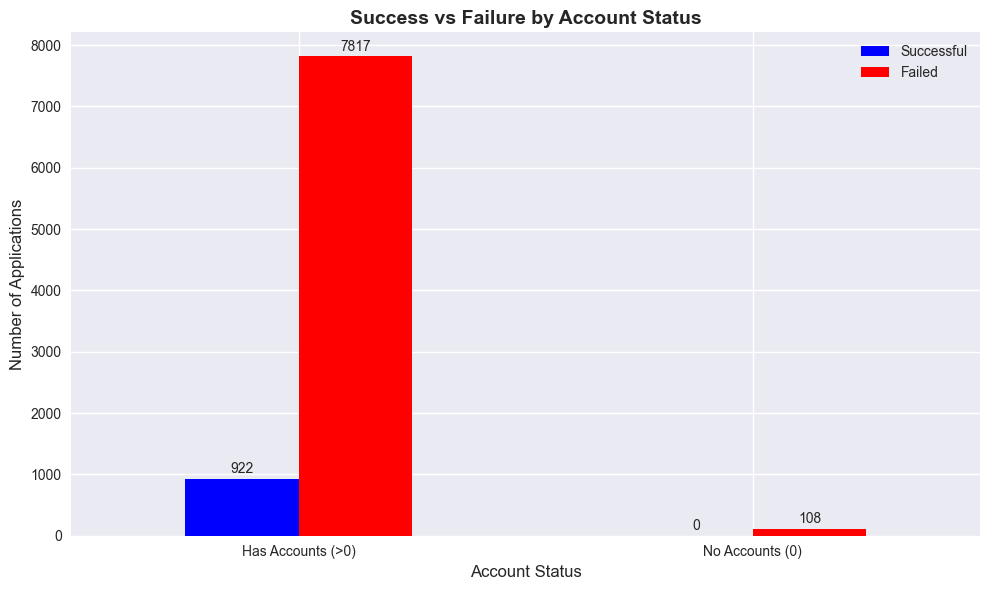

In [12]:
# Merge the two tables on UID
merged_df = application_df.merge(credit_df[['UID', 'ALL_Count']], on='UID', how='inner')

# Create a categorical column for ALL_Count
merged_df['ALL_Count_Category'] = merged_df['ALL_Count'].apply(
    lambda x: 'No Accounts (0)' if x == 0 else 'Has Accounts (>0)'
)

# Calculate success rate by ALL_Count category
success_by_all_count = merged_df.groupby('ALL_Count_Category').agg({
    'Success': ['sum', 'count', 'mean']
}).round(4)

# Rename columns for clarity
success_by_all_count.columns = ['Successful', 'Total Applications', 'Success Rate']
success_by_all_count['Failed'] = success_by_all_count['Total Applications'] - success_by_all_count['Successful']

# Reorder columns
success_by_all_count = success_by_all_count[['Total Applications', 'Successful', 'Failed', 'Success Rate']]

print("Success Rate by ALL_Count Status:")
display(success_by_all_count)

# Visualize with a single chart
fig, ax = plt.subplots(figsize=(10, 6))

success_by_all_count[['Successful', 'Failed']].plot(kind='bar', ax=ax, color=['blue', 'red'])
ax.set_title('Success vs Failure by Account Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Account Status', fontsize=12)
ax.set_ylabel('Number of Applications', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(['Successful', 'Failed'], loc='upper right')
add_bar_labels(ax)

plt.tight_layout()
plt.show()

<a id="traits"></a>
## 5. Personal Traits vs Success (Deliverable B)

### 5.1 Multivariate Logistic Assumption Checks

One of the most robust ways to understand key indicators of loan success is by building a logistic regression model based on our data and examining the interactions between attributes. I've built this analysis on the 2020 loan data to understand these relationships.

Because we're using a parametric linear model, we must adhere to several key assumptions before running the model:

**Linear Model Assumptions:**
1. ✅ Data points are independent of each other
2. ✅ Sample size is sufficient per predictor (8,621 observations, 23 features)
3. ✅ Linearity of log-odds for continuous variables (validated below)
4. ✅ No multicollinearity between independent variables (VIF < 5.5)
5. ✅ Extreme outliers removed (1.35% of observations with z-score > 3)
6. ✅ No perfect separation (applicants with zero credit accounts excluded)

#### 5.1.1 Merged Application Data and Credit Detail Data

**Introduction:** This section outlines the transformation of the raw application dataset into a finalized structure suitable for predictive modelling. The process involves converting categorical variables into machine-readable formats, aggregating temporal features, and enriching the dataset with external credit history.

Key Objectives Achieved:

- Categorical Encoding: Converted text-based variables (Term, Employment Type, Loan Purpose) and temporal data (Months to Quarters) into numerical binary vectors using One-Hot Encoding (with drop_first=True to prevent multicollinearity).

- Data Integration: Merged the application data with the credit_df dataset based on unique user IDs (UID) to create a holistic view of the applicant's profile.

- Noise Reduction: Removed features with zero variance (single-value columns) and filtered out records with no credit history (ALL_Count != 0) to avoid "perfect separation" issues and ensure model stability.

In [13]:
application_model_df = application_df[['UID', 'Month', 'Amount', 'Term_grouped', 'EmploymentType', 'LoanPurpose_grouped', 'Success']]

# Create Quarter column from Month
application_model_df["Quarter"] = application_model_df["Month"].dt.quarter

# Drop the Month column
application_model_df = application_model_df.drop(columns=["Month"])

# One-hot encode Term, EmploymentType, LoanPurpose_grouped, and Quarter columns
application_model_df = pd.get_dummies(
    application_model_df,
    columns=['Term_grouped', 'EmploymentType', 'LoanPurpose_grouped', 'Quarter'],
    drop_first=True,  # Avoid dummy variable trap
    dtype=int  # Use 0/1 integers instead of True/False
)

# View the new columns created
print("New columns after one-hot encoding:")
encoded_cols = [col for col in application_model_df.columns if 'Term_' in col or 'EmploymentType_' in col or 'LoanPurpose_grouped_' in col or 'Quarter_' in col]
print(encoded_cols)

# Check the shape
print(f"\nDataFrame shape: {application_model_df.shape}")

# combine two dataframes application_model and credit_features
combined_model_features_df = pd.merge(application_model_df, credit_df, on='UID', how='inner')
combined_model_features_df = combined_model_features_df[combined_model_features_df.ALL_Count != 0]

# remove column that only have one value
combined_model_features_df = combined_model_features_df.drop('ALL_TimeSinceMostRecentDefault', axis=1)

# remove rows that have ALL_Count = 0 (perfect separation)
combined_model_features_df = combined_model_features_df[combined_model_features_df['ALL_Count'] != 0]

# Preview
# display(combined_model_features_df.head())

New columns after one-hot encoding:
['Term_grouped_18-24', 'Term_grouped_30-36', 'Term_grouped_42-48', 'Term_grouped_54-60', 'EmploymentType_Employed - part time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_grouped_debt consolidation', 'LoanPurpose_grouped_furniture', 'LoanPurpose_grouped_home improvement', 'LoanPurpose_grouped_new car', 'LoanPurpose_grouped_others', 'Quarter_2', 'Quarter_3', 'Quarter_4']

DataFrame shape: (8847, 18)


/var/folders/kd/r6lzl_wd01g9l46l132g6wc00000gn/T/ipykernel_65501/1581367502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_model_df["Quarter"] = application_model_df["Month"].dt.quarter


#### 5.1.2 Feature Selections: Removing Multicollinearity

**Introduction:** This section focuses on refining the feature set by detecting and removing highly correlated independent variables. Multicollinearity can inflate the variance of coefficient estimates, making the Logistic Regression model unstable and difficult to interpret. To address this, we utilised the Variance Inflation Factor (VIF) metric to identify redundant features.

**`📊 Key Finding #7:`

- Threshold Applied: A VIF threshold of > 7.5 was used to flag features with problematic levels of multicollinearity.
- Why using threshold 7.5? Some variables have VIF value nearly above 5.0, it makes if we follow strictly to the rules (Features below VIF score 5) it will remove important variables like `Amount`.
- The code below attempt to remove highest VIF score once at a time, before re-calculating the score for remaining features. This process hinder us to remove excessive important features at the very first VIF score calculation. 

    - ❌ Removed #1: VIF = 560,152.45 (ALL_Count)
    - ❌ Removed #2: VIF = 18.34 (ALL_MeanAccountAge)
    - ❌ Removed #3: VIF = 9.30 (ALL_CountActive)

- **Final Decision:** Above variables will be dropped from the dataset prior to training the Logistic Regression model to ensure more reliable and robust predictions.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X, feature_cols):
    """Calculate VIF for all features"""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_cols
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

def vif_status(vif):
    if vif > 10:
        return "❌ High - Remove"
    elif vif > 5:
        return "⚠️ Moderate - Consider"
    else:
        return "✅ OK"

# Get feature columns (exclude UID and Success)
feature_cols = [col for col in combined_model_features_df.columns if col not in ['UID', 'Success']]
X = combined_model_features_df[feature_cols].copy()

# Iterative VIF removal
VIF_THRESHOLD = 7.5
removed_features = []
iteration = 0

print("Iterative VIF Analysis - Removing One Feature at a Time")
print("=" * 80)
print(f"Threshold: VIF > {VIF_THRESHOLD}")
print(f"Starting features: {len(feature_cols)}")
print("=" * 80)

while True:
    iteration += 1
    current_features = [col for col in feature_cols if col not in removed_features]
    X_current = combined_model_features_df[current_features]
    
    vif_data = calculate_vif(X_current, current_features)
    max_vif = vif_data["VIF"].max()
    max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
    
    if max_vif <= VIF_THRESHOLD:
        print(f"\n✅ Iteration {iteration}: All VIF values now ≤ {VIF_THRESHOLD}")
        break
    
    print(f"\n🔄 Iteration {iteration}: Highest VIF = {max_vif:,.2f} ({max_vif_feature})")
    removed_features.append(max_vif_feature)
    print(f"   ❌ Removed: {max_vif_feature}")

# Final summary
print("\n" + "=" * 80)
print("📊 SUMMARY")
print("=" * 80)
print(f"Features removed ({len(removed_features)}):")
for i, feat in enumerate(removed_features, 1):
    print(f"   {i}. {feat}")

print(f"\nRemaining features ({len(current_features)}):")
final_features = [col for col in feature_cols if col not in removed_features]

# Display final VIF table
vif_data["Status"] = vif_data["VIF"].apply(vif_status)
display(vif_data)

# Store final features for next cell
feature_cols_cleaned = final_features

Iterative VIF Analysis - Removing One Feature at a Time
Threshold: VIF > 7.5
Starting features: 28

🔄 Iteration 1: Highest VIF = 560,152.45 (ALL_Count)
   ❌ Removed: ALL_Count

🔄 Iteration 2: Highest VIF = 18.34 (ALL_MeanAccountAge)
   ❌ Removed: ALL_MeanAccountAge

🔄 Iteration 3: Highest VIF = 9.30 (ALL_CountActive)
   ❌ Removed: ALL_CountActive

✅ Iteration 4: All VIF values now ≤ 7.5

📊 SUMMARY
Features removed (3):
   1. ALL_Count
   2. ALL_MeanAccountAge
   3. ALL_CountActive

Remaining features (25):


,Feature,VIF,Status
0,Amount,5.043689,⚠️ Moderate - Consider
1,Term_grouped_54-60,4.713755,✅ OK
2,ALL_AgeOfOldestAccount,4.532467,✅ OK
3,ALL_CountClosedLast12Months,3.894110,✅ OK
4,ALL_CountOpenedLast12Months,3.780784,✅ OK
5,LoanPurpose_grouped_others,3.142681,✅ OK
6,Term_grouped_42-48,3.006610,✅ OK
7,ALL_CountSettled,2.974400,✅ OK
8,ALL_WorstPaymentStatusActiveAccounts,2.918026,✅ OK
9,ALL_CountDefaultAccounts,2.602349,✅ OK


In [21]:
# Prepare cleaned feature matrix using iteratively selected features
X_cleaned = combined_model_features_df[feature_cols_cleaned]

print(f"Original features: {len(feature_cols)}")
print(f"Features after iterative VIF removal: {len(feature_cols_cleaned)}")
print(f"Removed: {len(removed_features)} features")
print(f"\n✅ All remaining features have VIF ≤ {VIF_THRESHOLD}")

Original features: 28
Features after iterative VIF removal: 25
Removed: 3 features

✅ All remaining features have VIF ≤ 7.5


#### 5.1.3 Outliers Removal

**Introduction:** To improve model stability and prevent extreme values from skewing predictions, we addressed outliers in the *ALL_SumCurrentOutstandingBal* column. This feature exhibits a highly skewed distribution, with a significant gap between typical borrowers and high-value anomalies.

**Distribution Analysis:**
- Skewed Data: The data is heavily right-skewed, with a median balance of £13,062 compared to a much higher mean of £54,832.
- Extreme Values: The maximum outstanding balance reaches £4,004,808, which is vastly distant from the 99th percentile (£414,625).
- Standard Deviation: A high standard deviation of £107,935 confirms the presence of significant variability driven by these extreme high-value outliers.

**Action Taken:**

- Methodology: We applied the Z-score method to identify outliers, setting a threshold of > 3 Standard Deviations from the mean.
- Result: A total of 118 data points (representing 1.35% of the dataset) were identified as outliers and removed. These specific records had outstanding balances far exceeding the typical range, ensuring the model focuses on the representative majority of applicants rather than extreme edge cases.

Detailed Outlier Analysis: Monetary Columns

📊 Amount
--------------------------------------------------
   Min:    £500
   Max:    £20,000
   Mean:   £7,567
   Median: £6,500
   Std:    £5,309

   Percentiles:
   90th percentile: £15,000
   95th percentile: £20,000
   99th percentile: £20,000
   99.5th percentile: £20,000

   Z-score outliers (>3 SD): 0 (0.00%)

📊 ALL_SumCurrentOutstandingBal
--------------------------------------------------
   Min:    £0
   Max:    £4,004,808
   Mean:   £54,832
   Median: £13,062
   Std:    £107,935

   Percentiles:
   90th percentile: £171,120
   95th percentile: £232,584
   99th percentile: £414,625
   99.5th percentile: £542,812

   Z-score outliers (>3 SD): 118 (1.35%)

📊 ALL_SumCurrentOutstandingBalExcMtg
--------------------------------------------------
   Min:    £-1
   Max:    £581,415
   Mean:   £13,018
   Median: £8,523
   Std:    £17,808

   Percentiles:
   90th percentile: £29,769
   95th percentile: £40,156
   99th percentile: £64,746


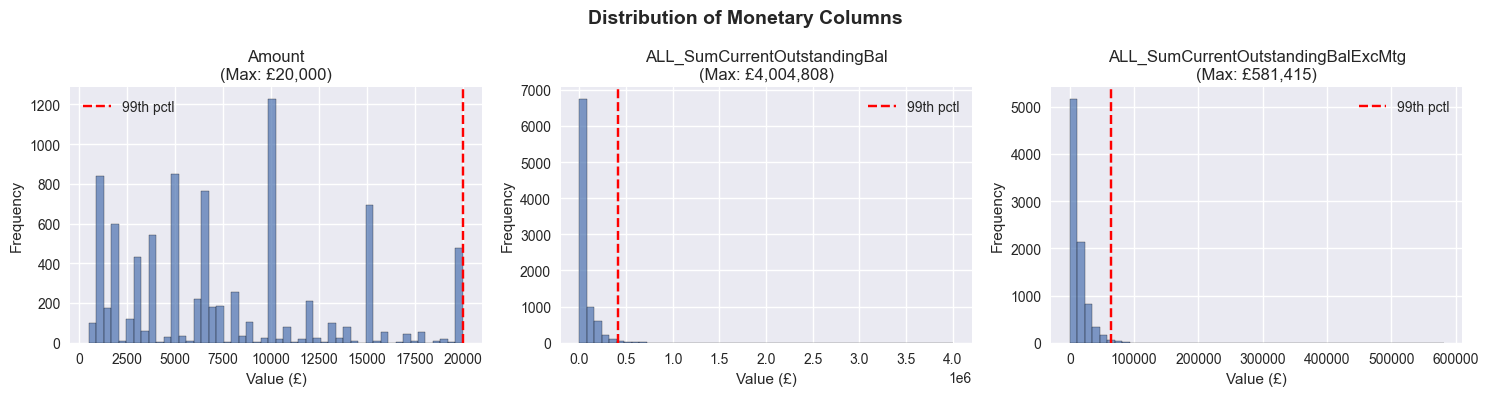

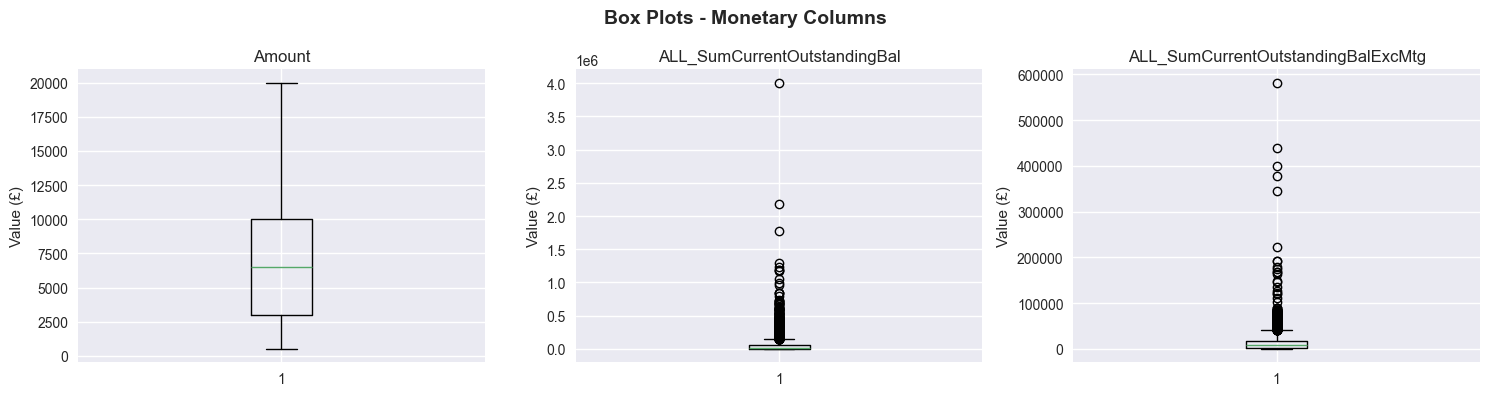

In [22]:
# Focus on monetary columns that could have extreme outliers
monetary_cols = ['Amount', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg']

# Check if columns exist in the dataframe
monetary_cols = [col for col in monetary_cols if col in combined_model_features_df.columns]

print("Detailed Outlier Analysis: Monetary Columns")
print("=" * 80)

for col in monetary_cols:
    data = combined_model_features_df[col]
    
    # Statistics
    print(f"\n📊 {col}")
    print("-" * 50)
    print(f"   Min:    £{data.min():,.0f}")
    print(f"   Max:    £{data.max():,.0f}")
    print(f"   Mean:   £{data.mean():,.0f}")
    print(f"   Median: £{data.median():,.0f}")
    print(f"   Std:    £{data.std():,.0f}")
    
    # Percentiles
    print(f"\n   Percentiles:")
    for p in [90, 95, 99, 99.5]:
        print(f"   {p}th percentile: £{data.quantile(p/100):,.0f}")
    
    # Z-score outliers
    z_outliers = ((data - data.mean()).abs() > 3 * data.std()).sum()
    print(f"\n   Z-score outliers (>3 SD): {z_outliers} ({z_outliers/len(data)*100:.2f}%)")

# Visualize distributions
fig, axes = plt.subplots(1, len(monetary_cols), figsize=(5*len(monetary_cols), 4))
if len(monetary_cols) == 1:
    axes = [axes]

for i, col in enumerate(monetary_cols):
    axes[i].hist(combined_model_features_df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[i].axvline(combined_model_features_df[col].quantile(0.99), color='red', linestyle='--', label='99th pctl')
    axes[i].set_title(f'{col}\n(Max: £{combined_model_features_df[col].max():,.0f})')
    axes[i].set_xlabel('Value (£)')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.suptitle('Distribution of Monetary Columns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Box plots
fig, axes = plt.subplots(1, len(monetary_cols), figsize=(5*len(monetary_cols), 4))
if len(monetary_cols) == 1:
    axes = [axes]

for i, col in enumerate(monetary_cols):
    axes[i].boxplot(combined_model_features_df[col])
    axes[i].set_title(col)
    axes[i].set_ylabel('Value (£)')

plt.suptitle('Box Plots - Monetary Columns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# Remove outliers where Z-score > 3 for ALL_SumCurrentOutstandingBal
col = 'ALL_SumCurrentOutstandingBal'
mean = combined_model_features_df[col].mean()
std = combined_model_features_df[col].std()

# Count before
rows_before = len(combined_model_features_df)

# Keep rows where Z-score <= 3
combined_model_features_df = combined_model_features_df[
    ((combined_model_features_df[col] - mean).abs() <= 3 * std)
]

# Count after
rows_after = len(combined_model_features_df)
rows_removed = rows_before - rows_after

#### 5.1.4 Linearity of Continuous Variables

**Summary of Visual Analysis:** The visual inspection of the Log-Odds plots reveals distinct relationships for the three monetary attributes:

- `Amount`: Displays a generally consistent negative linear relationship, where higher loan amounts correlate with lower log-odds of success, although there is some variance at the extreme ends of the distribution.

- `ALL_SumCurrentOutstandingBal`: Shows a positive trend, but the relationship is noisier with data points deviating more significantly from the linear fit compared to the other variables.

- `ALL_SumCurrentOutstandingBalExcMtg`: Demonstrates the strongest linear adherence among the three, with the binned data points closely tracking the negative trend line, indicating a robust inverse relationship between non-mortgage outstanding balance and the log-odds of success.

Conclusion: Overall, the linearity assumption appears reasonably satisfied for these variables, with `ALL_SumCurrentOutstandingBalExcMtg` showing the cleanest linear signal.

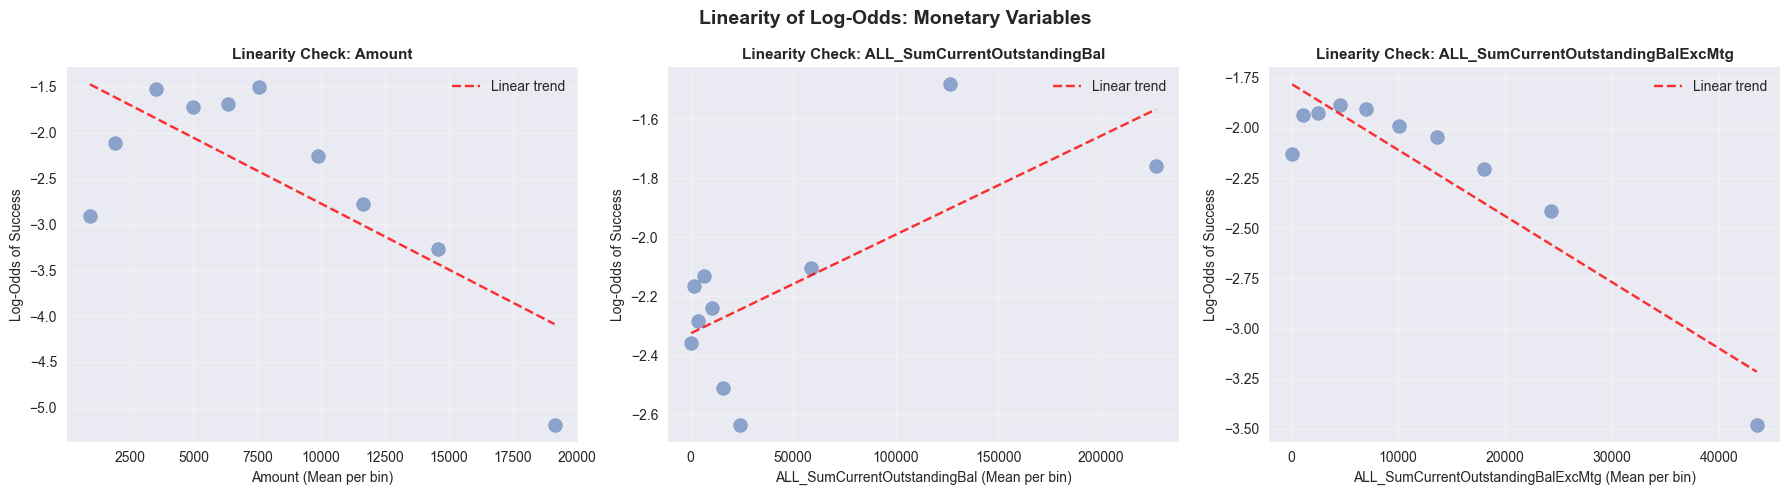

Linearity Assessment:
If points roughly follow the red line → Linear relationship ✓
If points show U-shape, J-shape, or threshold → Non-linear ✗


In [18]:
# Test linearity of log-odds for monetary columns
monetary_cols = ['Amount', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(monetary_cols):
    ax = axes[i]
    
    # Bin the continuous variable into deciles
    combined_model_features_df[f'{col}_binned'] = pd.qcut(
        combined_model_features_df[col], 
        q=10, 
        labels=False, 
        duplicates='drop'
    )
    
    # Calculate success rate and log-odds for each bin
    binned_stats = combined_model_features_df.groupby(f'{col}_binned').agg({
        col: 'mean',  # Average value in bin
        'Success': ['mean', 'sum', 'count']
    })
    
    binned_stats.columns = ['Mean_Value', 'Success_Rate', 'Success_Count', 'Total_Count']
    
    # Calculate log-odds (with small constant to avoid log(0))
    binned_stats['Log_Odds'] = np.log((binned_stats['Success_Rate'] + 0.001) / (1 - binned_stats['Success_Rate'] + 0.001))
    
    # Plot: Mean value vs Log-odds
    ax.scatter(binned_stats['Mean_Value'], binned_stats['Log_Odds'], s=100, alpha=0.6)
    
    # Add linear trend line
    z = np.polyfit(binned_stats['Mean_Value'], binned_stats['Log_Odds'], 1)
    p = np.poly1d(z)
    ax.plot(binned_stats['Mean_Value'], p(binned_stats['Mean_Value']), "r--", alpha=0.8, label='Linear trend')
    
    ax.set_xlabel(f'{col} (Mean per bin)', fontsize=10)
    ax.set_ylabel('Log-Odds of Success', fontsize=10)
    ax.set_title(f'Linearity Check: {col}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Linearity of Log-Odds: Monetary Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("Linearity Assessment:")
print("=" * 80)
print("If points roughly follow the red line → Linear relationship ✓")
print("If points show U-shape, J-shape, or threshold → Non-linear ✗")
print("=" * 80)

<a id="model_insights_1"></a>
## 5.2 Logistic Regression Analysis: Predicting Application Success

**`📊 Key Finding #8:`**   

Logistic Regression Analysis: Predicting Success
This section evaluates which applicant characteristics and behaviours significantly influence the likelihood of a successful loan outcome. By analyzing the Odds Ratios, we can quantify how much a specific trait increases or decreases the probability of success compared to the baseline.

1. Key Personal & Behavioral Traits Linked to Success
The model identified several distinct profiles that correlate strongly with loan repayment success:

- Loan Term Selection (The "Sweet Spot"): The strongest predictor of success is the term length chosen by the applicant. Applicants who selected intermediate terms (between 2.5 to 5 years) showed exponentially higher success rates compared to the baseline (typically very short or very long terms).
    - 3.5x higher likelihood of success for terms of 42–48 months.
    - 2.9x higher likelihood of success for terms of 30–36 months.
    - 2.4x higher likelihood of success for terms of 54–60 months.


2. Employment Stability:  
- Self-Employment Risk: Being Self-Employed is associated with a 31% lower likelihood of success (Odds Ratio: 0.69) compared to full-time employees, although this finding is marginally significant ($p=0.09$). This suggests income volatility may play a role in repayment reliability.
- Note: "Retired" and "Part-time" statuses did not show a statistically significant difference from full-time employment, implying they are as reliable as the standard employee in this dataset.

3. Credit Discipline vs. Credit Seeking:

- Credit Seeking (High Risk): For every additional account opened in the last 12 months, the odds of success drop by 21%. Frequent applications for new credit are a strong signal of financial stress.
- Past Defaults (High Risk): Each historical default associated with an applicant reduces their success probability by 21%.
- Payment History (Critical): A worsening in the "Worst Payment Status" significantly reduces success odds by 24%, highlighting that past behaviour is a robust predictor of future performance.

4. Seasonal Behavior:

- Applications submitted in Q2, Q3, and Q4 are significantly more likely to succeed (26%–40% higher odds) compared to Q1. This suggests a "New Year Slump" where Q1 applicants may be financially strained post-holidays or shopping for consolidation loans that carry higher risk.

In [19]:
import statsmodels.api as sm
import numpy as np

# Prepare X and y
X = combined_model_features_df[feature_cols_cleaned]
y = combined_model_features_df['Success']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit multivariate logistic regression
print("Fitting Multivariate Logistic Regression...")
print("=" * 80)

model = sm.Logit(y, X_const)
result = model.fit()

# Display full summary
print(result.summary())

# Create cleaner results table
results_df = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'Std_Error': result.bse.values,
    'Z_Score': result.tvalues.values,
    'P_Value': result.pvalues.values,
    'Odds_Ratio': np.exp(result.params.values),
    'CI_Lower': np.exp(result.conf_int()[0].values),
    'CI_Upper': np.exp(result.conf_int()[1].values)
})

# Add significance indicator
results_df['Significant'] = results_df['P_Value'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))

# Round for readability
results_df['Coefficient'] = results_df['Coefficient'].round(4)
results_df['Odds_Ratio'] = results_df['Odds_Ratio'].round(4)
results_df['P_Value'] = results_df['P_Value'].round(4)
results_df['CI_Lower'] = results_df['CI_Lower'].round(4)
results_df['CI_Upper'] = results_df['CI_Upper'].round(4)

# Sort by p-value
results_df = results_df.sort_values('P_Value').reset_index(drop=True)

print("\n\n")
print("=" * 80)
print("Multivariate Logistic Regression Results (Sorted by Significance)")
print("=" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("=" * 80)

display(results_df)

# Show only significant features
print("\n\nSignificant Features Only (p < 0.05):")
print("=" * 80)
sig_results = results_df[results_df['Significant'] != '']

print(f"\n📊 Summary:")
# print(f"   Total features: {len(feature_cols_final)}")
print(f"   Significant features (p < 0.05): {len(sig_results)}")
print(f"   Pseudo R-squared: {result.prsquared:.4f}")

Fitting Multivariate Logistic Regression...
Optimization terminated successfully.
         Current function value: 0.272106
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                Success   No. Observations:                 8621
Model:                          Logit   Df Residuals:                     8597
Method:                           MLE   Df Model:                           23
Date:                Mon, 22 Dec 2025   Pseudo R-squ.:                  0.1946
Time:                        11:38:54   Log-Likelihood:                -2345.8
converged:                       True   LL-Null:                       -2912.7
Covariance Type:            nonrobust   LLR p-value:                4.333e-225
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const   

,Feature,Coefficient,Std_Error,Z_Score,P_Value,Odds_Ratio,CI_Lower,CI_Upper,Significant
0,const,-0.9066,2.100756e-01,-4.315778,0.0000,0.4039,0.2676,0.6096,***
1,ALL_SumCurrentOutstandingBal,0.0000,5.197633e-07,10.890317,0.0000,1.0000,1.0000,1.0000,***
2,ALL_CountOpenedLast12Months,-0.2296,2.619885e-02,-8.765013,0.0000,0.7948,0.7550,0.8367,***
3,ALL_CountDefaultAccounts,-0.2373,5.015491e-02,-4.730841,0.0000,0.7888,0.7149,0.8703,***
4,ALL_AgeOfYoungestAccount,-0.0178,3.939867e-03,-4.514331,0.0000,0.9824,0.9748,0.9900,***
5,ALL_SumCurrentOutstandingBalExcMtg,-0.0000,3.938685e-06,-10.099905,0.0000,1.0000,1.0000,1.0000,***
6,ALL_WorstPaymentStatusActiveAccounts,-0.2782,2.829899e-02,-9.831722,0.0000,0.7571,0.7163,0.8003,***
7,Amount,-0.0002,1.167365e-05,-17.100498,0.0000,0.9998,0.9998,0.9998,***
8,Term_grouped_54-60,0.8922,1.797582e-01,4.963124,0.0000,2.4404,1.7157,3.4711,***
9,Term_grouped_30-36,1.0555,1.698777e-01,6.213004,0.0000,2.8733,2.0596,4.0084,***




Significant Features Only (p < 0.05):

📊 Summary:
   Significant features (p < 0.05): 16
   Pseudo R-squared: 0.1946
